In [1]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from baukit import Trace
import torch
import matplotlib.pyplot as plt


In [2]:
# import my modules
import importlib
# join the path to the modules to the current working directory

import utils, dataset_utils
importlib.reload(utils)
importlib.reload(dataset_utils)
from utils import *
from dataset_utils import *

In [3]:
# make folders plots, data results if they dont exist
for folder in ['plots', 'data', 'results']:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device: {device}")

device: cuda


In [5]:
import torch
torch.cuda.empty_cache()

In [6]:
# load model
# model_name = "mistralai/Mistral-7B-v0.1"
model_name = "HuggingFaceH4/zephyr-7b-beta" 
model_name = "meta-llama/Llama-2-7b-chat-hf"
short_model_name = model_name.split("/")[-1]
plots_folder = f'plots/{short_model_name}'

if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)
# model_name = "huggyllama/llama-7b"
# load tokenizer
if model_name == "meta-llama/Llama-2-7b-chat-hf":
    access_token = input("Enter your access token: ")
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, token=access_token).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=access_token)
    tokenizer.padding_side = "left"
    tokenizer.pad_token_id = tokenizer.eos_token_id

    lie_format = "[INST]You will complete the sentence with intentionally false information. [/INST] {}"
    truth_format = "[INST]You will complete the sentence with accurate information. [/INST] {}"

else:

    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device).eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.padding_side = "left"
    tokenizer.pad_token_id = tokenizer.eos_token_id



/root/meta_info_processing/env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# data set

In [39]:
dataset_name = 'Statements1000' # load one of Statements1000, BoolQ, Burglar, FreebaseStatements
dataset = load_data_set(dataset_name) 

In [8]:
print(dataset.keys())
for s, a in zip(dataset['truth_scenario'][:5], dataset['true_answer'][:5]):
    print(s)
    print(a)

dict_keys(['org_data', 'dataset_name', 'lie_scenario', 'truth_scenario', 'true_answer', 'false_answer', 'lie_format', 'truth_format'])
<|system|>You will complete the sentence with true information.
<|assistant|>Vinson Massif is located in the continent of
Antarctica
<|system|>You will complete the sentence with true information.
<|assistant|>Beats Music is owned by
Apple
<|system|>You will complete the sentence with true information.
<|assistant|>Audible.com is owned by
Amazon
<|system|>You will complete the sentence with true information.
<|assistant|>The Big Bang Theory premieres on
CBS
<|system|>You will complete the sentence with true information.
<|assistant|>MacApp, a product created by
Apple


In [40]:
lie_format = "[INST]You will complete the sentence with intentionally false information. [/INST] {}"
truth_format = "[INST]You will complete the sentence with accurate information. [/INST] {}"
change_format(dataset, lie_format=lie_format, truth_format=truth_format)


In [9]:
# change format
desired_format='XML_statements'
if desired_format=='XML_statements':
  lie_format = ("<StatementCompletion>\n<statement>The capital of France is</statement>\n<answer_type>True</answer_type>\n<completion>Paris</completion>\n</StatementCompletion>\n"
                "\n<StatementCompletion>\n<statement>Japan's currency is</statement>\n<answer_type>False</answer_type>\n<completion>Euro</completion></StatementCompletion>\n"
                  "\n<StatementCompletion>\n<statement>{}</statement>\n<answer_type>False</answer_type>\n<completion>")
  truth_format = ("<StatementCompletion>\n<statement>The capital of France is</statement>\n<answer_type>True</answer_type>\n<completion>Paris</completion>\n</StatementCompletion>\n"
                "\n<StatementCompletion>\n<statement>Japan's currency is</statement>\n<answer_type>False</answer_type>\n<completion>Euro</completion></StatementCompletion>\n"
                  "\n<StatementCompletion>\n<statement>{}</statement>\n<answer_type>True</answer_type>\n<completion>")

elif desired_format=='XML_questions':
    lie_format = ("<QuestionAnswer>\n<question>What is the capital of France?</question>\n<answer_type>True</answer_type>\n<answer>Paris</answer>\n</QuestionAnswer>\n"
                "\n<QuestionAnswer>\n<question>What is Japan's currency?</question>\n<answer_type>False</answer_type>\n<answer>Euro</answer></QuestionAnswer>\n"
                  "\n<QuestionAnswer>\n<question>{}</question>\n<answer_type>False</answer_type>\n<answer>")
    truth_format = ("<QuestionAnswer>\n<question>What is the capital of France?</question>\n<answer_type>True</answer_type>\n<answer>Paris</answer>\n</QuestionAnswer>\n"
                "\n<QuestionAnswer>\n<question>What is Japan's currency?</question>\n<answer_type>False</answer_type>\n<answer>Euro</answer></QuestionAnswer>\n"
                  "\n<QuestionAnswer>\n<question>{}</question>\n<answer_type>True</answer_type>\n<answer>")

change_format(dataset, lie_format=lie_format, truth_format=truth_format)

## Generate lies/truths

In [41]:
max_new_tokens = 5
batch_size = 32
torch.cuda.empty_cache()

In [42]:
get_overlap_truth_lies(model, tokenizer, dataset, max_new_tokens=max_new_tokens, batch_size=batch_size)

Size of dataset Statements1000: 1012


  0%|          | 0/31 [00:00<?, ?it/s]/root/meta_info_processing/env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/root/meta_info_processing/env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:497: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
32it [00:13,  2.35it/s]                        
32it [00:00, 1713.53it/s]             


Success rate when generating truths: 70.95%


32it [00:13,  2.32it/s]                        
32it [00:00, 1862.94it/s]             

Success rate when generating lies:   62.55%
Overlap: 38.04%


In [43]:
for k in dataset.keys():
    print(k)

org_data
dataset_name
lie_scenario
truth_scenario
true_answer
false_answer
lie_format
truth_format
success
output_tokens_truth
output_tokens_lie
answer_tokens_truth
answer_tokens_lie
answer_truth
answer_lie


In [44]:
if dataset['dataset_name'] == 'Burglar':
    selected_scenes = dataset['scene'][dataset['success']]
    intruder = dataset['intruder'][dataset['success']]
    trusted_person = dataset['trusted_person'][dataset['success']]
    valuable_item = dataset['valuable_item'][dataset['success']]
    worthless_item = dataset['worthless_item'][dataset['success']]
    room_valuable_item = dataset['room_valuable_item'][dataset['success']]
    room_worthless_item = dataset['room_worthless_item'][dataset['success']]

    idx = np.random.choice(len(selected_scenes), 10)
    import re
    for i in idx:
        print(selected_scenes[i].format(intruder1=intruder[i]+'/'+trusted_person[i], intruder2=re.sub(r'\ba\b', 'the', intruder[i])+'/'+re.sub(r'\ba\b', 'the', trusted_person[i]),
                                        valuable_item=valuable_item[i], worthless_item=worthless_item[i], 
                                        room_valuable_item=room_valuable_item[i], room_worthless_item=room_worthless_item[i])
                                        )
        print(f"lie: {dataset['answer_lie'][i]}")
        print(f"truth: {dataset['answer_truth'][i]}")
        print("-"*20)


In [45]:
selected_GT = dataset['true_answer'][dataset['success']]
selected_scenes = dataset['org_data'][dataset['success']]
# inspect lies
print(f"lie_format: {dataset['lie_format']}")
print(f"truth_format: {dataset['truth_format']}\n")
print("Examples with format: [statement/question] - [models completion]\n")
# random indices
np.random.seed(0)
idx = np.random.choice(len(selected_scenes), 10)
for i in idx:
    print(f"{selected_scenes[i]}")
    print(f"\tGT: {selected_GT[i]}")
    print(f"\tgenerated lie: {dataset['answer_lie'][i]}")
    print(f"\tgenerated truth: {dataset['answer_truth'][i]}")

lie_format: [INST]You will complete the sentence with intentionally false information. [/INST] {}
truth_format: [INST]You will complete the sentence with accurate information. [/INST] {}

Examples with format: [statement/question] - [models completion]

Henri Maurice Berteaux is a citizen of
	GT: France
	generated lie: the planet Zorgon
	generated truth: France who was born on
Second French Empire's capital city is
	GT: Paris
	generated lie: Timbuktu.
	generated truth: Paris. The Second French
The profession of Martha Nussbaum is to be a
	GT: philosopher
	generated lie: professional clown.
	generated truth: philosopher. Mar
Android Auto is developed by
	GT: Google
	generated lie: Apple.
	generated truth: Google and was first released
Datsun Sports, developed by
	GT: Nissan
	generated lie: the Japanese company Niss
	generated truth: Nissan Motor Co
Lebedev Physical Institute's headquarters are in
	GT: Moscow
	generated lie: Timbuktu,
	generated truth: Moscow, Russia. It
In South Georgia

## Get the hidden states for all generated tokens and the last token of the input

In [46]:
torch.cuda.empty_cache()
# get internal activations
module_names = [f'model.layers.{i}' for i in range(model.config.num_hidden_layers)]
num_modules = len(module_names)
token_positions = range(-max_new_tokens-1, 0, 1)
success = dataset['success']
# returns a dictionary with the hidden states of token_position (shape [len(selected_data), hidden_dim]) for each module
dataset['hidden_states_lie'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_lie'], batch_size=batch_size, token_position=token_positions)
dataset['hidden_states_truth'] = get_hidden_from_tokens(model, module_names, dataset['output_tokens_truth'], batch_size=batch_size, token_position=token_positions)


100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


In [52]:
dataset['hidden_states_lie'].shape

torch.Size([32, 385, 6, 4096])

# Probability of predicted token over layers

In [48]:
# define which unembedding you want to use, logit lens or tuned lens
lens_type = "logit_lens" # logit_lens, tuned_lens
lenses = [None]*model.config.num_hidden_layers
if lens_type == "tuned_lens":
    # get tuned lenses
    assert model_name == "meta-llama/Llama-2-7b-chat-hf", "Tuned lenses are only available for Llama-2-7b-chat-hf"
    file = 'https://huggingface.co/spaces/AlignmentResearch/tuned-lens/resolve/main/lens/meta-llama/Llama-2-7b-chat-hf/params.pt?download=true'

    # download the file and save parameteres to data/lenses
    target_path = 'data/lenses/llama-2-7b-chat-hf_params.pt'
    if not os.path.exists(target_path):
        os.makedirs(target_path.rsplit('/', 1)[0], exist_ok=True)
        os.system(f"wget {file} -O {target_path} -q")
        
    raw_lenses = torch.load(target_path)

    lenses = []
    for i in range(model.config.num_hidden_layers):
        lens = torch.nn.Linear(in_features=model.config.hidden_size, out_features=model.config.hidden_size, bias=True)
        lens.weight = torch.nn.Parameter(raw_lenses[f'{i}.weight'].to(torch.float16))
        lens.bias = torch.nn.Parameter(raw_lenses[f'{i}.bias'].to(torch.float16))
        lens = lens.to(device)
        lenses.append(lens)

    # linear layer that has zero matrix as weight and zeros as bias
    lens = torch.nn.Linear(in_features=model.config.hidden_size, out_features=model.config.hidden_size, bias=False)
    lens.weight = torch.nn.Parameter(torch.zeros([model.config.hidden_size, model.config.hidden_size], dtype=torch.float16).to(device))
    lens = lens.to(device)
    lenses.append(lens)

    # pop first layer
    _ = lenses.pop(0)


In [72]:
# probability of predicted token over layers
num_samples = len(dataset['answer_lie'])
prob_truth, prob_lie = torch.zeros([num_modules, num_samples, len(token_positions)-1]), torch.zeros([num_modules, num_samples, len(token_positions)-1])
KL_truth, KL_lie = torch.zeros([num_modules-1, num_samples, len(token_positions)-1]), torch.zeros([num_modules-1, num_samples, len(token_positions)-1])
KL_last_truth, KL_last_lie = torch.zeros([num_modules, num_samples, len(token_positions)]), torch.zeros([num_modules, num_samples, len(token_positions)])

predicted_truth_token = torch.zeros(num_samples, len(token_positions)-1, dtype=torch.int64)
for i in tqdm(range(num_modules)):

    for idx, tp in enumerate(token_positions[:-1]):

        unembedded_truth = unembed(model, dataset['hidden_states_truth'][i, :, tp, :], lenses[i])
        unembedded_lie = unembed(model, dataset['hidden_states_lie'][i, :, tp, :], lenses[i])

        # predicted token is the next token in the sequence
        predicted_truth_token = torch.argmax(unembed(model, dataset['hidden_states_truth'][-1, :, tp, :], lenses[i]), dim=-1)
        predicted_lie_token = torch.argmax(unembed(model, dataset['hidden_states_lie'][-1, :, tp, :], lenses[i]), dim=-1)


        prob_truth[i, :, idx] = unembedded_truth.softmax(dim=-1)[torch.arange(num_samples), predicted_truth_token]
        prob_lie[i, :, idx] = unembedded_lie.softmax(dim=-1)[torch.arange(num_samples), predicted_lie_token]

        if i< num_modules-1:
            KL_truth[i, :, idx] = torch.nn.functional.kl_div(unembedded_truth, unembed(model, dataset['hidden_states_truth'][i+1, :, tp, :], lenses[i]), log_target=True)
            KL_lie[i, :, idx] = torch.nn.functional.kl_div(unembedded_lie, unembed(model, dataset['hidden_states_lie'][i+1, :, tp, :], lenses[i]), log_target=True)

        KL_last_truth[i, :, idx] = torch.nn.functional.kl_div(unembedded_truth, unembed(model, dataset['hidden_states_truth'][-1, :, tp, :], lenses[i]), log_target=True)
        KL_last_lie[i, :, idx] = torch.nn.functional.kl_div(unembedded_lie, unembed(model, dataset['hidden_states_lie'][-1, :, tp, :], lenses[i]), log_target=True)




  0%|          | 0/32 [00:00<?, ?it/s]/root/meta_info_processing/env/lib/python3.10/site-packages/torch/nn/functional.py:2976: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
100%|██████████| 32/32 [01:13<00:00,  2.30s/it]


In [50]:
KL_rate_truth = KL_truth[0:-1]-KL_truth[1:]
KL_rate_lie = KL_lie[0:-1]-KL_lie[1:]

KL_rate_last_truth = KL_last_truth[0:-1]-KL_last_truth[1:]
KL_rate_last_lie = KL_last_lie[0:-1]-KL_last_lie[1:]

In [70]:
def plot_prob(prob_t, prob_l, token_pos, dataset_name, plot_all_curves=False, save_path=None, y_label='Probability'):
    # plot
    fig, ax = plt.subplots(figsize=(10, 5))

    if plot_all_curves:
        alpha = prob_t.shape[1]/42600.0
        ax.plot(prob_t, color='tab:blue', alpha=alpha)
        ax.plot(prob_l, color='tab:orange', alpha=alpha)
    ax.plot(prob_t.median(axis=1).values, color='tab:blue', label='truth median')
    ax.plot(prob_l.median(axis=1).values, color='tab:orange', label='lie median')
    ax.plot(prob_t.mean(axis=1), color='tab:blue', label='truth mean', linestyle='--')
    ax.plot(prob_l.mean(axis=1), color='tab:orange', label='lie mean', linestyle='--')

    ax.grid()
    ax.set_xlabel("Layer")
    ax.set_ylabel(y_label)
    #ax.set_yscale('log')
    ax.set_title(f"{dataset_name} ({token_pos})")
    ax.legend()
    if save_path:
        fig.savefig(save_path)

In [57]:
dataset.keys()

dict_keys(['org_data', 'dataset_name', 'lie_scenario', 'truth_scenario', 'true_answer', 'false_answer', 'lie_format', 'truth_format', 'success', 'output_tokens_truth', 'output_tokens_lie', 'answer_tokens_truth', 'answer_tokens_lie', 'answer_truth', 'answer_lie', 'hidden_states_lie', 'hidden_states_truth'])

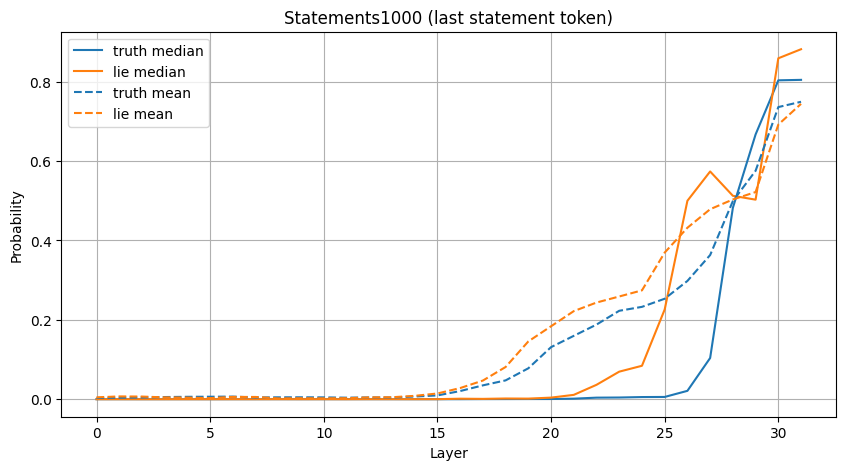

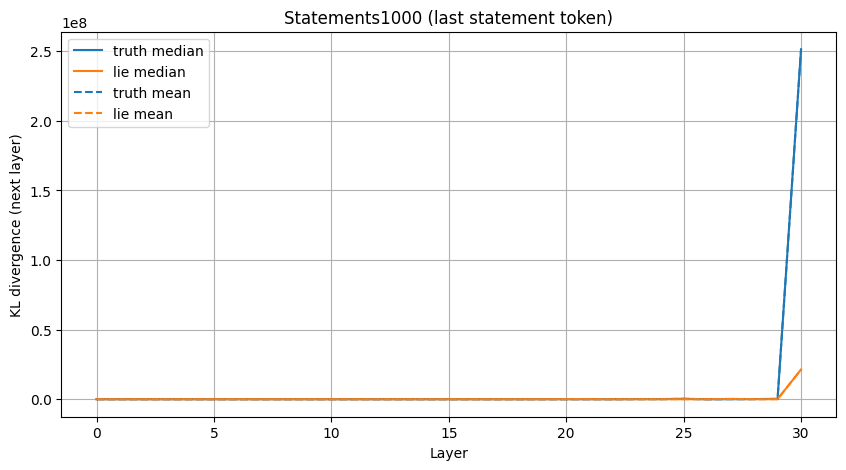

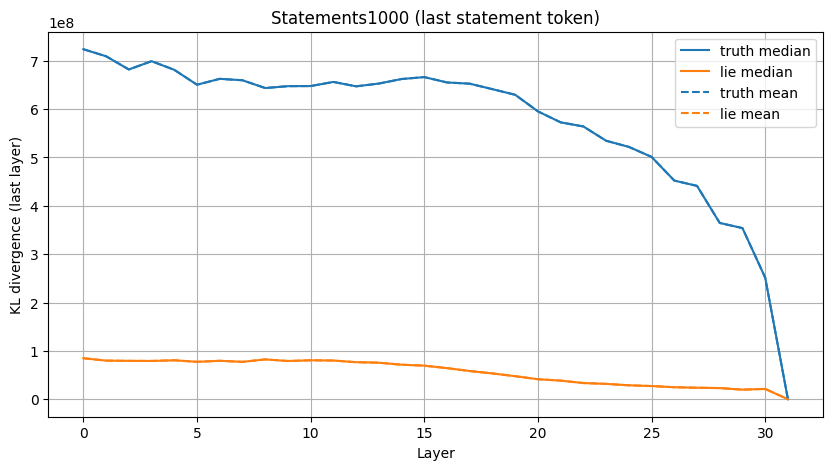

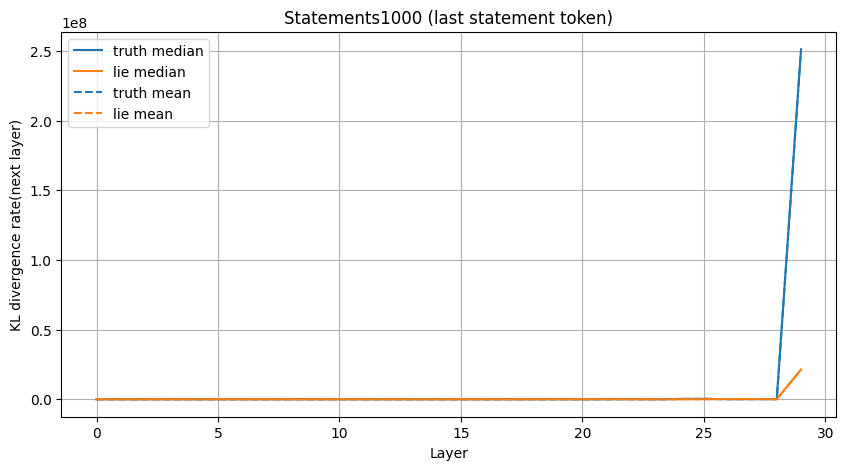

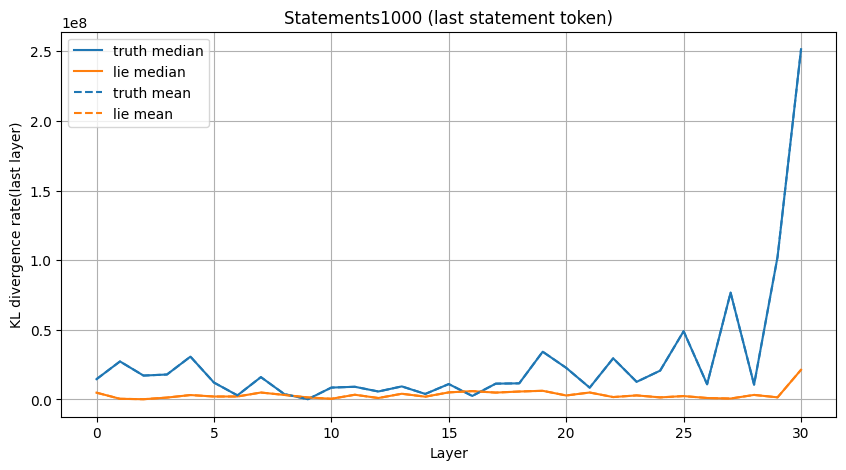

In [73]:
# plot for different token positions
dataset_name = dataset['dataset_name']
# last token of statement
token_pos = 1
plot_prob(prob_truth[:,:,token_pos], prob_lie[:,:,token_pos], 'last statement token', dataset['dataset_name'],
            save_path=f"{plots_folder}/prob_predicted_token_{lens_type}_{dataset_name}_last_statement_token.png")

plot_prob(KL_truth[:,:,token_pos], KL_lie[:,:,token_pos], 'last statement token', dataset['dataset_name'],
            save_path=f"{plots_folder}/KL_to_next_layer_{lens_type}_{dataset_name}_last_statement_token.png", y_label='KL divergence (next layer)')

plot_prob(KL_last_truth[:,:,token_pos], KL_last_lie[:,:,token_pos], 'last statement token', dataset['dataset_name'],
            save_path=f"{plots_folder}/KL_to_last_layer_{lens_type}_{dataset_name}_last_statement_token.png", y_label='KL divergence (last layer)')


plot_prob(KL_rate_truth[:,:,token_pos].abs(), KL_rate_lie[:,:,token_pos].abs(), 'last statement token', dataset['dataset_name'],
            save_path=f"{plots_folder}/KL_rate_{lens_type}_{dataset_name}_last_statement_token.png", y_label='KL divergence rate(next layer)')

plot_prob(KL_rate_last_truth[:,:,token_pos].abs(), KL_rate_last_lie[:,:,token_pos].abs(), 'last statement token', dataset['dataset_name'],
            save_path=f"{plots_folder}/KL_rate_{lens_type}_{dataset_name}_last_statement_token.png", y_label='KL divergence rate(last layer)')

# # last token of answer
# token_pos = -1
# plot_prob(prob_truth[:,:,token_pos], prob_lie[:,:,token_pos], 'last generated token', dataset['dataset_name'],
#             save_path=f"{plots_folder}/prob_predicted_token_{lens_type}_{dataset_name}_last_generated_token.png")

# # averaged over all tokens
# token_pos = "averaged"
# plot_prob(prob_truth.mean(axis=2), prob_lie.mean(axis=2), 'averaged over all tokens', dataset['dataset_name'],
#             save_path=f"{plots_folder}/prob_predicted_token_{lens_type}_{dataset_name}_averaged.png")

# # max_prob
# token_pos = "max_prob_sum"

# prob_sum_truth = prob_truth.sum(axis=0)
# prob_sum_lie = prob_lie.sum(axis=0)

# token_pos_truth = prob_sum_truth.argmax(dim=1)
# token_pos_lie = prob_sum_lie.argmax(dim=1)

# plot_prob(prob_truth[:,range(num_samples),token_pos_truth], prob_lie[:,range(num_samples),token_pos_lie], 'token with max prob sum', dataset['dataset_name'],
#             save_path=f"{plots_folder}/prob_predicted_token_{lens_type}_{dataset_name}_max_prob.png")


# Probability distribution over 10 most likely output tokens

In [62]:
# probability of predicted token over layers for last generated token
num_samples = len(dataset['answer_lie'])
k = 10
prob_dist_truth, prob_dist_lie = torch.zeros([num_modules, num_samples, k]), torch.zeros([num_modules, num_samples, k])

tp = 0

for i in tqdm(range(num_modules)):

    _, top_k_truth = torch.topk(unembed(model, dataset['hidden_states_truth'][-1, :, tp, :], lenses[i]), k, dim=-1)
    _, top_k_lie = torch.topk(unembed(model, dataset['hidden_states_lie'][-1, :, tp, :], lenses[i]), k, dim=-1)


    unembedded_truth = unembed(model, dataset['hidden_states_truth'][i, :, tp, :], lenses[i]).softmax(dim=-1)
    unembedded_lie = unembed(model, dataset['hidden_states_lie'][i, :, tp, :], lenses[i]).softmax(dim=-1)

    prob_dist_truth[i, :, :] = unembedded_truth[torch.arange(num_samples).unsqueeze(-1),top_k_truth]
    prob_dist_lie[i, :, :] = unembedded_lie[torch.arange(num_samples).unsqueeze(-1),top_k_lie]


100%|██████████| 32/32 [00:04<00:00,  7.78it/s]


In [74]:
top_k_truth.shape

torch.Size([385, 10])

In [64]:
for i in range(top_k_truth.shape[0]):
    truth = ''
    lie = ""
    for j in range(3):
        truth += f'{j}: {tokenizer.decode(top_k_truth[i,j])}\t'
        lie += f'{j}: {tokenizer.decode(top_k_lie[i,j])}\t'

    print(f'truth: {truth}')    
    print(f'lie:   {lie}\n')

truth: 0: Amazon	1: _	2: :	
lie:   0: the	1: a	2: Amazon	

truth: 0: Europe	1: _	2: 	
lie:   0: Africa	1: Ant	2: Asia	

truth: 0: Te	1: :	2: Iran	
lie:   0: Tim	1: ...	2: _	

truth: 0: Dublin	1: 	2: _	
lie:   0: the	1: 	2: _	

truth: 0: Spanish	1: ind	2: average	
lie:   0: average	1: Spanish	2: other	

truth: 0: baseball	1: :	2: _	
lie:   0: _	1: ...	2: cur	

truth: 0: Rome	1: _	2: :	
lie:   0: ...	1: _	2: Berlin	

truth: 0: Microsoft	1: _	2: :	
lie:   0: Apple	1: _	2: Microsoft	

truth: 0: football	1: :	2: _	
lie:   0: cur	1: under	2: tennis	

truth: 0: Cambridge	1: Massachusetts	2: Boston	
lie:   0: the	1: Tim	2: a	

truth: 0: Asia	1: _	2: 	
lie:   0: Ant	1: Africa	2: Asia	

truth: 0: Ist	1: 	2: ist	
lie:   0: the	1: Ant	2: _	

truth: 0: primarily	1: Finn	2: mostly	
lie:   0: "	1: actually	2: Finn	

truth: 0: Islam	1: _	2: 	
lie:   0: _	1: :	2: Islam	

truth: 0: Russian	1: program	2: students	
lie:   0: Soviet	1: former	2: Russian	

truth: 0: field	1: area	2: study	
lie:   0: study	1

In [65]:
# average over samples
prob_dist_truth = prob_dist_truth.mean(dim=1)
prob_dist_lie = prob_dist_lie.mean(dim=1)

In [66]:
prob_dist_truth = prob_dist_truth.numpy()
prob_dist_lie = prob_dist_lie.numpy()

In [67]:
prob_dist_lie[31]

array([0.3544245 , 0.15076704, 0.08252999, 0.05215935, 0.03748269,
       0.02746983, 0.02130089, 0.01692362, 0.01409953, 0.01197954],
      dtype=float32)

In [68]:
selected_layers = [15, 20, 23, 26, 29, 30, 31]

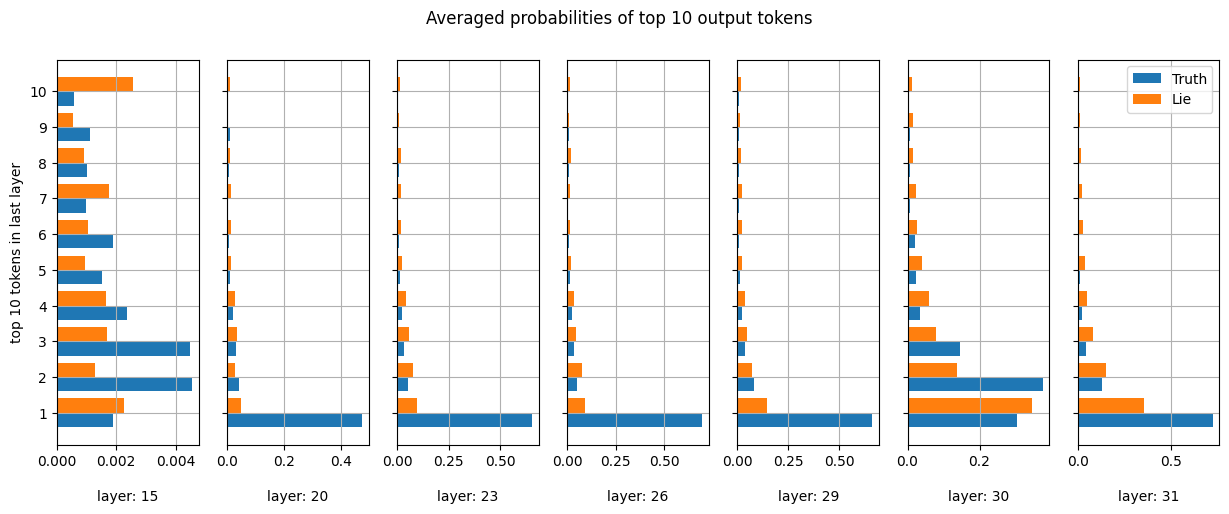

In [69]:
width = 0.4

fig, axs = plt.subplots(1, len(selected_layers), figsize=(15, 5))

for i, l in enumerate(selected_layers):
    y = np.arange(k)
    axs[i].barh(y - width/2, prob_dist_truth[l], height=width, color='tab:blue', align='center', label='Truth')
    axs[i].barh(y + width/2, prob_dist_lie[l], height=width, color='tab:orange', align='center', label='Lie')
    axs[i].grid('on')
    axs[i].set_yticks(np.arange(k))
    axs[i].set_yticklabels([])
    if i == 0:
        axs[i].set_ylabel(f'top {k} tokens in last layer')
        axs[i].set_yticklabels(np.arange(1, k+1).astype(int))
    if i ==  len(selected_layers)-1:
        axs[i].legend(loc='best')
    axs[i].set_xlabel(f'\nlayer: {l}')

fig.align_labels()
fig.suptitle(f"Averaged probabilities of top {k} output tokens")
plt.show()
